In [1]:
# Import libraries
import numpy as np
import random
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import time
from tqdm import tqdm
import json
from argparse import ArgumentParser


In [2]:
# Constants
unk = '<UNK>'

# Feedforward Neural Network (FFNN) class
class FFNN(nn.Module):
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation = nn.ReLU()  # ReLU activation function
        self.output_dim = 5
        self.W2 = nn.Linear(h, self.output_dim)
        self.softmax = nn.LogSoftmax(dim=1)  # Softmax function across rows (for log-probabilities)
        self.loss = nn.NLLLoss()  # Cross-entropy/negative log likelihood loss

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector):
        # Ensure the input has batch dimension
        if input_vector.dim() == 1:
            input_vector = input_vector.unsqueeze(0)  # Add batch dimension

        # Hidden layer computation
        h = self.W1(input_vector)  # Linear transformation for hidden layer
        h = self.activation(h)  # Apply ReLU activation

        # Output layer computation
        z = self.W2(h)  # Linear transformation to get logits

        # Softmax to get probability distribution
        predicted_vector = self.softmax(z)  # Convert logits to log-probabilities

        return predicted_vector


In [3]:
# Create vocabulary from dataset
def make_vocab(data):
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab

# Generate word2index and index2word mappings
def make_indices(vocab):
    vocab_list = sorted(vocab)
    vocab_list.append(unk)
    word2index = {word: idx for idx, word in enumerate(vocab_list)}
    index2word = {idx: word for idx, word in enumerate(vocab_list)}
    vocab.add(unk)
    return vocab, word2index, index2word

# Convert dataset to vector representation using word2index
def convert_to_vector_representation(data, word2index):
    vectorized_data = []
    for document, y in data:
        vector = torch.zeros(len(word2index))
        for word in document:
            index = word2index.get(word, word2index[unk])
            vector[index] += 1
        vectorized_data.append((vector, y))
    return vectorized_data

# Load data from JSON files
def load_data(train_data, val_data):
    with open(train_data) as training_f:
        training = json.load(training_f)
    with open(val_data) as valid_f:
        validation = json.load(valid_f)

    tra = [(elt["text"].split(), int(elt["stars"] - 1)) for elt in training]
    val = [(elt["text"].split(), int(elt["stars"] - 1)) for elt in validation]

    return tra, val


In [26]:
    parser = ArgumentParser()
    parser.add_argument("-hd", "--hidden_dim", type=int, default=50, help="Hidden layer dimension")
    parser.add_argument("-e", "--epochs", type=int, default=10, help="Number of epochs to train")
    parser.add_argument("--train_data", default=r"C:\Users\LENOVO\Downloads\training.json", help="Path to training data")
    parser.add_argument("--val_data", default=r"C:\Users\LENOVO\Downloads\validation.json", help="Path to validation data")
    parser.add_argument("--test_data", default=r"C:\Users\LENOVO\Downloads\test.json", help="Path to test data")
    parser.add_argument('--do_train', action='store_true')
    args = parser.parse_args([])

In [27]:
# Fix random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

# Load data (update file paths if necessary)
train_data_path = "/content/training.json"  # replace with your training file path
val_data_path = "/content/validation.json"  # replace with your validation file path

print("========== Loading data ==========")
train_data, valid_data = load_data(train_data_path, val_data_path)
vocab = make_vocab(train_data)
vocab, word2index, index2word = make_indices(vocab)

# Vectorize data
print("========== Vectorizing data ==========")
train_data = convert_to_vector_representation(train_data, word2index)
valid_data = convert_to_vector_representation(valid_data, word2index)


========== Loading data ==========
========== Vectorizing data ==========


In [28]:
# Initialize model, optimizer, and training parameters
model = FFNN(input_dim=len(vocab), h=args.hidden_dim)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [29]:
# Initialize the lists to store accuracies and losses before starting the training loop
train_accuracies = []
val_accuracies = []
train_losses = []  # List to store training losses

print("========== Training for {} epochs ==========".format(args.epochs))

for epoch in range(args.epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    correct = 0
    total = 0
    epoch_loss = 0  # To accumulate the loss for this epoch
    start_time = time.time()
    print("Training started for epoch {}".format(epoch + 1))

    random.shuffle(train_data)  # Shuffle training data each epoch
    minibatch_size = 16
    N = len(train_data)

    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None

        for example_index in range(minibatch_size):
            input_vector, gold_label = train_data[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector)

            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1, -1), torch.tensor([gold_label]))

            if loss is None:
                loss = example_loss
            else:
                loss += example_loss

        loss = loss / minibatch_size  # Average the loss over the minibatch
        epoch_loss += loss.item()  # Accumulate the loss for this epoch
        loss.backward()  # Backpropagation
        optimizer.step()  # Parameter update

    train_accuracy = (correct / total) * 100  # Training accuracy
    train_losses.append(epoch_loss)  # Store training loss for this epoch
    train_accuracies.append(train_accuracy)  # Store training accuracy for this epoch
    print("Training completed for epoch {}".format(epoch + 1))
    print("Training accuracy for epoch {}: {:.2f}%".format(epoch + 1, train_accuracy))
    print("Training loss for epoch {}: {:.4f}".format(epoch + 1, epoch_loss))
    print("Training time for this epoch: {:.2f} seconds".format(time.time() - start_time))

    # Validation phase
    correct = 0
    total = 0
    start_time = time.time()
    print("Validation started for epoch {}".format(epoch + 1))

    for minibatch_index in tqdm(range(len(valid_data) // minibatch_size)):
        loss = None

        for example_index in range(minibatch_size):
            index = minibatch_index * minibatch_size + example_index
            if index >= len(valid_data):
                break

            input_vector, gold_label = valid_data[index]
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector)

            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1, -1), torch.tensor([gold_label]))

            if loss is None:
                loss = example_loss
            else:
                loss += example_loss

        loss = loss / minibatch_size

    val_accuracy = (correct / total) * 100  # Validation accuracy
    val_accuracies.append(val_accuracy)  # Store validation accuracy for this epoch

    print("Validation completed for epoch {}".format(epoch + 1))
    print("Validation accuracy for epoch {}: {:.2f}%".format(epoch + 1, val_accuracy))
    print("Validation time for this epoch: {:.2f} seconds".format(time.time() - start_time))


========== Training for 10 epochs ==========
Training started for epoch 1


100%|██████████| 500/500 [01:02<00:00,  7.99it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 52.70%
Training loss for epoch 1: 499.7069
Training time for this epoch: 62.59 seconds
Validation started for epoch 1


100%|██████████| 50/50 [00:01<00:00, 42.65it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 53.50%
Validation time for this epoch: 1.18 seconds
Training started for epoch 2


100%|██████████| 500/500 [01:08<00:00,  7.34it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 58.56%
Training loss for epoch 2: 439.4029
Training time for this epoch: 68.18 seconds
Validation started for epoch 2


100%|██████████| 50/50 [00:01<00:00, 42.70it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 59.38%
Validation time for this epoch: 1.18 seconds
Training started for epoch 3


100%|██████████| 500/500 [01:13<00:00,  6.79it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 62.25%
Training loss for epoch 3: 408.1412
Training time for this epoch: 73.70 seconds
Validation started for epoch 3


100%|██████████| 50/50 [00:01<00:00, 34.37it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 59.62%
Validation time for this epoch: 1.47 seconds
Training started for epoch 4


100%|██████████| 500/500 [01:14<00:00,  6.73it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 64.53%
Training loss for epoch 4: 384.4756
Training time for this epoch: 74.36 seconds
Validation started for epoch 4


100%|██████████| 50/50 [00:01<00:00, 45.81it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 59.62%
Validation time for this epoch: 1.10 seconds
Training started for epoch 5


100%|██████████| 500/500 [01:13<00:00,  6.80it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 65.10%
Training loss for epoch 5: 381.8557
Training time for this epoch: 73.53 seconds
Validation started for epoch 5


100%|██████████| 50/50 [00:01<00:00, 35.00it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 59.75%
Validation time for this epoch: 1.44 seconds
Training started for epoch 6


100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 68.44%
Training loss for epoch 6: 351.9873
Training time for this epoch: 76.43 seconds
Validation started for epoch 6


100%|██████████| 50/50 [00:01<00:00, 35.40it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 61.00%
Validation time for this epoch: 1.42 seconds
Training started for epoch 7


100%|██████████| 500/500 [01:16<00:00,  6.53it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 71.84%
Training loss for epoch 7: 321.4100
Training time for this epoch: 76.61 seconds
Validation started for epoch 7


100%|██████████| 50/50 [00:01<00:00, 38.67it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 52.62%
Validation time for this epoch: 1.30 seconds
Training started for epoch 8


100%|██████████| 500/500 [01:16<00:00,  6.53it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 72.61%
Training loss for epoch 8: 315.6991
Training time for this epoch: 76.61 seconds
Validation started for epoch 8


100%|██████████| 50/50 [00:01<00:00, 37.31it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 59.25%
Validation time for this epoch: 1.35 seconds
Training started for epoch 9


100%|██████████| 500/500 [01:16<00:00,  6.51it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 75.20%
Training loss for epoch 9: 290.6766
Training time for this epoch: 76.77 seconds
Validation started for epoch 9


100%|██████████| 50/50 [00:01<00:00, 38.94it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 60.25%
Validation time for this epoch: 1.29 seconds
Training started for epoch 10


100%|██████████| 500/500 [01:17<00:00,  6.46it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 78.03%
Training loss for epoch 10: 267.7458
Training time for this epoch: 77.43 seconds
Validation started for epoch 10


100%|██████████| 50/50 [00:01<00:00, 47.78it/s]

Validation completed for epoch 10
Validation accuracy for epoch 10: 59.00%
Validation time for this epoch: 1.06 seconds


In [30]:
test_data_path = "/content/test.json"

# Load and vectorize test data
print("========== Testing ==========")
test_data, _ = load_data(test_data_path, val_data_path)
test_data = convert_to_vector_representation(test_data, word2index)

# Test loop
model.eval()
correct = 0
total = 0
for i in range(len(test_data)):
    test_vector, test_label = test_data[i]
    test_pred_vector = model(test_vector)
    test_pred_label = torch.argmax(test_pred_vector)
    correct += int(test_pred_label == test_label)
    total += 1

print("TEST ACCURACY: {:.2f}%".format((correct / total) * 100))

========== Testing ==========
TEST ACCURACY: 13.50%


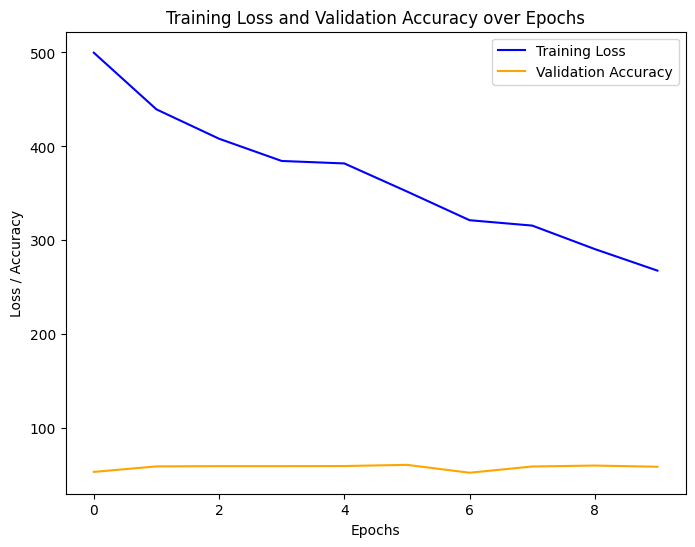

In [32]:
import matplotlib.pyplot as plt

# Check if train_losses and val_accuracies have been populated with data
if len(train_losses) == 0 or len(val_accuracies) == 0:
    print("train_losses or val_accuracies are empty. Please check your data.")
else:
    # Define the number of epochs based on the data length
    epochs = len(train_losses)  # assuming train_losses and val_accuracies are of equal length

    # Plot training loss and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(epochs), train_losses, label="Training Loss", color="blue")
    plt.plot(range(epochs), val_accuracies, label="Validation Accuracy", color="orange")

    # Adding labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Accuracy")
    plt.title("Training Loss and Validation Accuracy over Epochs")
    plt.legend()

    # Show plot
    plt.show()
